# OpenLifelogQA Evaluation Results Comparison

This notebook compares three different retrieval and generation configurations:
1. **Baseline (BM25)**: Using BM25 (pyserini) for retrieval and top-retrieved memory for generation
2. **SBert (all-MiniLM-L6-v2)**: Dense embedding approach using SBert embeddings
3. **Qwen3-Embedding (0.6B)**: Dense embedding approach using Qwen3-Embedding 0.6B

We analyze retrieval metrics (Precision, Recall, MRR, NDCG, AQWV) and generation metrics across all configurations.

In [25]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# Load the three result files
baseline_path = "runs/openlifelog_qa_baseline.json"
sbert_path = "runs/openlifelog_qa_sbert.json"
qwen3_path = "runs/openlifelog_qa_qwen3_0.6B.json"

with open(baseline_path) as f:
    baseline_data = json.load(f)

with open(sbert_path) as f:
    sbert_data = json.load(f)

with open(qwen3_path) as f:
    qwen3_data = json.load(f)

print(f"Loaded {len(baseline_data['queries'])} queries from baseline")
print(f"Loaded {len(sbert_data['queries'])} queries from sbert")
print(f"Loaded {len(qwen3_data['queries'])} queries from qwen3")

Loaded 1508 queries from baseline
Loaded 1508 queries from sbert
Loaded 1508 queries from qwen3


## 1. Global Metrics Comparison Table

First, we'll create a comprehensive table comparing the key retrieval metrics across all three configurations.

In [26]:
# Extract global retrieval metrics from all three configurations
def extract_global_metrics(data, config_name):
    metrics = data["retrieval_metrics"]
    return {
        "Configuration": config_name,
        "Precision": metrics["precision"],
        "Recall": metrics["recall"],
        "F1": metrics["f1"],
        "MRR": metrics["mrr"],
        "NDCG@10": metrics["ndcg@10"],
        "NDCG@20": metrics["ndcg@20"],
        "AQWV": metrics["aqwv"],
        "MAP": metrics["map"],
        "P@1": metrics["precision@1"],
        "P@5": metrics["precision@5"],
        "P@10": metrics["precision@10"],
        "R@1": metrics["recall@1"],
        "R@5": metrics["recall@5"],
        "R@10": metrics["recall@10"],
    }


# Create comparison dataframe
global_metrics = pd.DataFrame([
    extract_global_metrics(baseline_data, "Baseline (BM25)"),
    extract_global_metrics(sbert_data, "SBert (all-MiniLM-L6-v2)"),
    extract_global_metrics(qwen3_data, "Qwen3-Embedding (0.6B)"),
])

# Display the table
print("=" * 100)
print("GLOBAL RETRIEVAL METRICS COMPARISON")
print("=" * 100)
display(global_metrics.set_index("Configuration").round(4))

# Calculate improvements over baseline
print("\n" + "=" * 100)
print("IMPROVEMENTS OVER BASELINE (%)")
print("=" * 100)
baseline_row = global_metrics[
    global_metrics["Configuration"] == "Baseline (BM25)"
].iloc[0]
improvements = []
for _idx, row in global_metrics.iterrows():
    if row["Configuration"] != "Baseline (BM25)":
        improvement = {}
        improvement["Configuration"] = row["Configuration"]
        for col in global_metrics.columns:
            if col != "Configuration":
                baseline_val = baseline_row[col]
                if baseline_val != 0:
                    improvement[col] = ((row[col] - baseline_val) / baseline_val) * 100
                else:
                    improvement[col] = 0
        improvements.append(improvement)

improvements_df = pd.DataFrame(improvements)
display(improvements_df.set_index("Configuration").round(2))

GLOBAL RETRIEVAL METRICS COMPARISON


,Precision,Recall,F1,MRR,NDCG@10,NDCG@20,AQWV,MAP,P@1,P@5,P@10,R@1,R@5,R@10
Configuration,,,,,,,,,,,,,,
Baseline (BM25),0.0440,0.5071,0.0770,0.2768,0.2814,0.3121,0.4793,0.2369,0.1870,0.0984,0.0684,0.1280,0.2998,0.3983
SBert (all-MiniLM-L6-v2),0.0119,0.1463,0.0214,0.0770,0.0730,0.0847,0.1176,0.0592,0.0491,0.0228,0.0165,0.0346,0.0777,0.1072
Qwen3-Embedding (0.6B),0.0359,0.4105,0.0634,0.2850,0.2619,0.2825,0.3825,0.2201,0.2122,0.0919,0.0583,0.1379,0.2748,0.3397



IMPROVEMENTS OVER BASELINE (%)


,Precision,Recall,F1,MRR,NDCG@10,NDCG@20,AQWV,MAP,P@1,P@5,P@10,R@1,R@5,R@10
Configuration,,,,,,,,,,,,,,
SBert (all-MiniLM-L6-v2),-72.95,-71.15,-72.19,-72.17,-74.06,-72.87,-75.47,-75.00,-73.76,-76.82,-75.85,-72.97,-74.09,-73.09
Qwen3-Embedding (0.6B),-18.46,-19.06,-17.73,2.95,-6.91,-9.47,-20.21,-7.09,13.48,-6.60,-14.74,7.70,-8.34,-14.73


## 2. Precision-Recall Curves at Different K Values

We'll plot Precision@K and Recall@K for k=1, 5, 10, 20 for all three configurations.

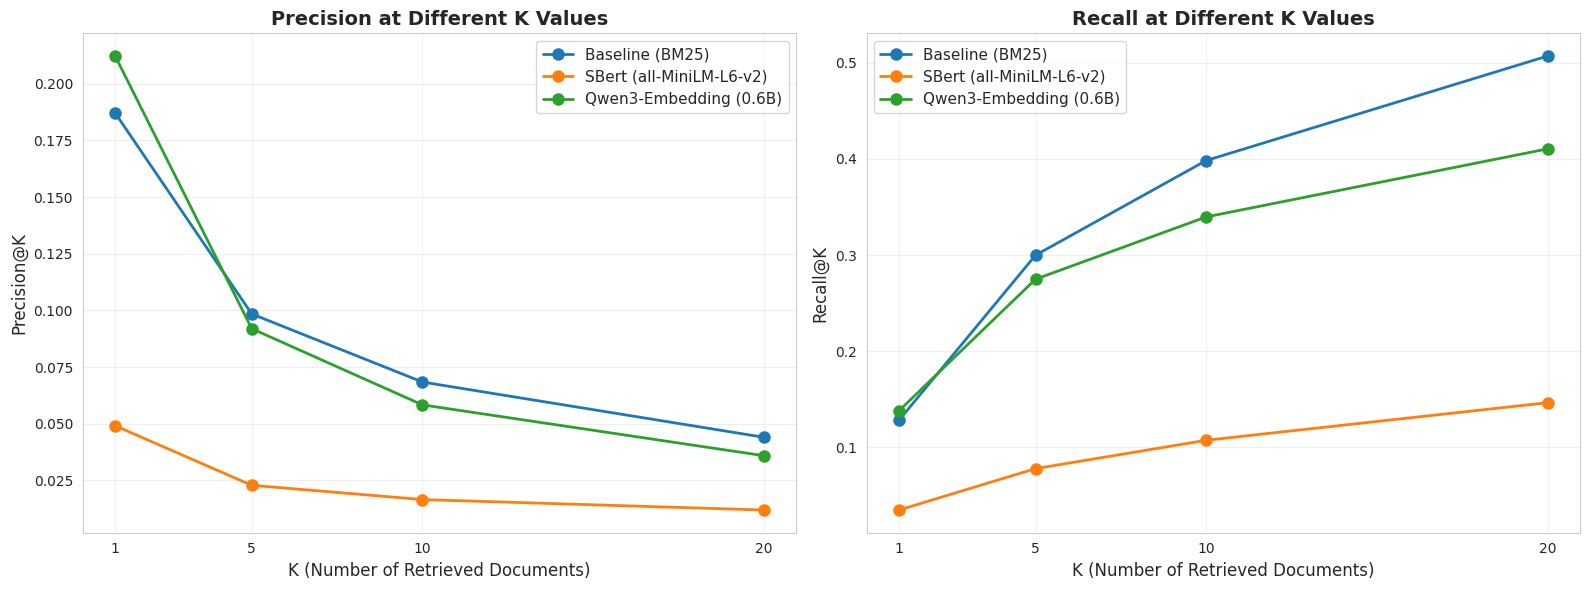

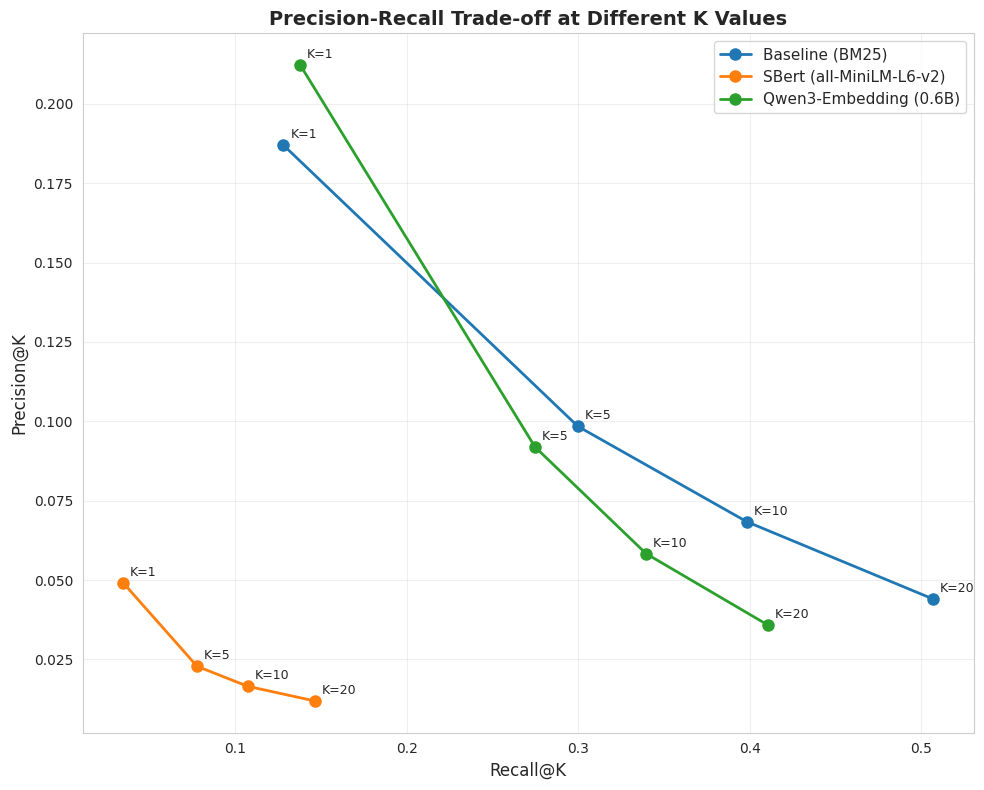

In [27]:
# Extract Precision@K and Recall@K for different K values
k_values = [1, 5, 10, 20]


def extract_pk_rk(data, config_name):
    metrics = data["retrieval_metrics"]
    return {
        "Configuration": config_name,
        "P@1": metrics["precision@1"],
        "P@5": metrics["precision@5"],
        "P@10": metrics["precision@10"],
        "P@20": metrics["precision@20"],
        "R@1": metrics["recall@1"],
        "R@5": metrics["recall@5"],
        "R@10": metrics["recall@10"],
        "R@20": metrics["recall@20"],
    }


pk_rk_data = pd.DataFrame([
    extract_pk_rk(baseline_data, "Baseline (BM25)"),
    extract_pk_rk(sbert_data, "SBert (all-MiniLM-L6-v2)"),
    extract_pk_rk(qwen3_data, "Qwen3-Embedding (0.6B)"),
])

# Create Precision-Recall curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Precision@K
for _idx, row in pk_rk_data.iterrows():
    precision_values = [row["P@1"], row["P@5"], row["P@10"], row["P@20"]]
    ax1.plot(
        k_values,
        precision_values,
        marker="o",
        linewidth=2,
        markersize=8,
        label=row["Configuration"],
    )

ax1.set_xlabel("K (Number of Retrieved Documents)", fontsize=12)
ax1.set_ylabel("Precision@K", fontsize=12)
ax1.set_title("Precision at Different K Values", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_values)

# Plot Recall@K
for _idx, row in pk_rk_data.iterrows():
    recall_values = [row["R@1"], row["R@5"], row["R@10"], row["R@20"]]
    ax2.plot(
        k_values,
        recall_values,
        marker="o",
        linewidth=2,
        markersize=8,
        label=row["Configuration"],
    )

ax2.set_xlabel("K (Number of Retrieved Documents)", fontsize=12)
ax2.set_ylabel("Recall@K", fontsize=12)
ax2.set_title("Recall at Different K Values", fontsize=14, fontweight="bold")
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(k_values)

plt.tight_layout()
plt.show()

# Create Precision-Recall trade-off plot
fig, ax = plt.subplots(figsize=(10, 8))

for _idx, row in pk_rk_data.iterrows():
    precision_values = [row["P@1"], row["P@5"], row["P@10"], row["P@20"]]
    recall_values = [row["R@1"], row["R@5"], row["R@10"], row["R@20"]]
    ax.plot(
        recall_values,
        precision_values,
        marker="o",
        linewidth=2,
        markersize=8,
        label=row["Configuration"],
    )

    # Annotate k values
    for i, k in enumerate(k_values):
        ax.annotate(
            f"K={k}",
            (recall_values[i], precision_values[i]),
            textcoords="offset points",
            xytext=(5, 5),
            ha="left",
            fontsize=9,
        )

ax.set_xlabel("Recall@K", fontsize=12)
ax.set_ylabel("Precision@K", fontsize=12)
ax.set_title(
    "Precision-Recall Trade-off at Different K Values", fontsize=14, fontweight="bold"
)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. MRR and NDCG at Different K Values

Now we'll plot MRR@K and NDCG@K for k=1, 3, 5, 10, 20.

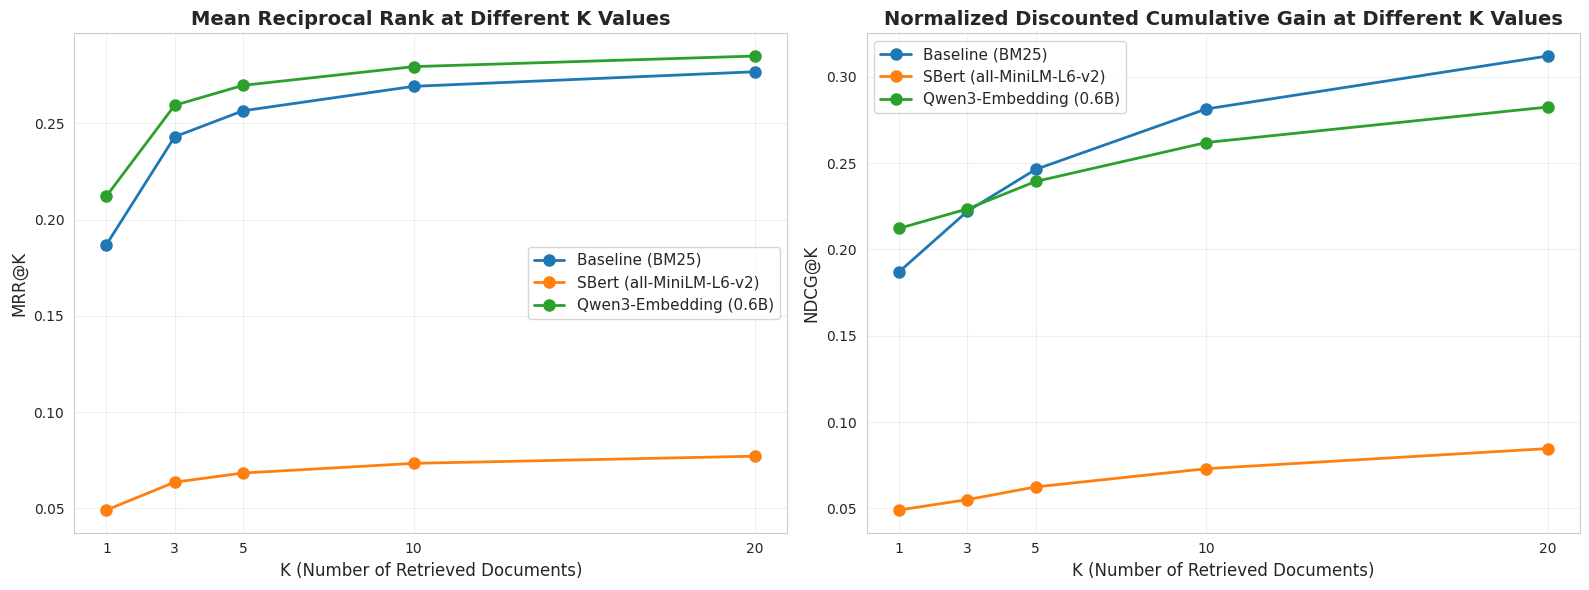

In [28]:
# Extract MRR@K and NDCG@K for different K values
k_values_extended = [1, 3, 5, 10, 20]


def extract_mrr_ndcg(data, config_name):
    metrics = data["retrieval_metrics"]
    return {
        "Configuration": config_name,
        "MRR@1": metrics["mrr@1"],
        "MRR@3": metrics["mrr@3"],
        "MRR@5": metrics["mrr@5"],
        "MRR@10": metrics["mrr@10"],
        "MRR@20": metrics["mrr@20"],
        "NDCG@1": metrics["ndcg@1"],
        "NDCG@3": metrics["ndcg@3"],
        "NDCG@5": metrics["ndcg@5"],
        "NDCG@10": metrics["ndcg@10"],
        "NDCG@20": metrics["ndcg@20"],
    }


mrr_ndcg_data = pd.DataFrame([
    extract_mrr_ndcg(baseline_data, "Baseline (BM25)"),
    extract_mrr_ndcg(sbert_data, "SBert (all-MiniLM-L6-v2)"),
    extract_mrr_ndcg(qwen3_data, "Qwen3-Embedding (0.6B)"),
])

# Create MRR and NDCG plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot MRR@K
for _idx, row in mrr_ndcg_data.iterrows():
    mrr_values = [
        row["MRR@1"],
        row["MRR@3"],
        row["MRR@5"],
        row["MRR@10"],
        row["MRR@20"],
    ]
    ax1.plot(
        k_values_extended,
        mrr_values,
        marker="o",
        linewidth=2,
        markersize=8,
        label=row["Configuration"],
    )

ax1.set_xlabel("K (Number of Retrieved Documents)", fontsize=12)
ax1.set_ylabel("MRR@K", fontsize=12)
ax1.set_title(
    "Mean Reciprocal Rank at Different K Values", fontsize=14, fontweight="bold"
)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_values_extended)

# Plot NDCG@K
for _idx, row in mrr_ndcg_data.iterrows():
    ndcg_values = [
        row["NDCG@1"],
        row["NDCG@3"],
        row["NDCG@5"],
        row["NDCG@10"],
        row["NDCG@20"],
    ]
    ax2.plot(
        k_values_extended,
        ndcg_values,
        marker="o",
        linewidth=2,
        markersize=8,
        label=row["Configuration"],
    )

ax2.set_xlabel("K (Number of Retrieved Documents)", fontsize=12)
ax2.set_ylabel("NDCG@K", fontsize=12)
ax2.set_title(
    "Normalized Discounted Cumulative Gain at Different K Values",
    fontsize=14,
    fontweight="bold",
)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(k_values_extended)

plt.tight_layout()
plt.show()

## 4. Per-Query Statistical Significance Testing

We'll perform statistical significance tests on the per-query metrics to determine if the differences between configurations are statistically significant. We'll use:
1. **Paired Approximate Randomization Test (PAR)**: A non-parametric test that doesn't assume normal distribution
2. **Wilcoxon Signed-Rank Test**: A robust alternative for paired samples

In [29]:
# Extract per-query metrics
def extract_per_query_metrics(data):
    """Extract key metrics for each query"""
    metrics = []
    for query in data["queries"]:
        if "retrieval_metrics" in query:
            metrics.append({
                "query_id": query["query_id"],
                "precision": query["retrieval_metrics"].get("precision", 0),
                "recall": query["retrieval_metrics"].get("recall", 0),
                "mrr": query["retrieval_metrics"].get("mrr", 0),
                "ndcg@10": query["retrieval_metrics"].get("ndcg@10", 0),
                "ndcg@20": query["retrieval_metrics"].get("ndcg@20", 0),
                "f1": query["retrieval_metrics"].get("f1", 0),
            })
    return pd.DataFrame(metrics)


baseline_per_query = extract_per_query_metrics(baseline_data)
sbert_per_query = extract_per_query_metrics(sbert_data)
qwen3_per_query = extract_per_query_metrics(qwen3_data)

print(f"Extracted per-query metrics for {len(baseline_per_query)} queries")
print(f"Baseline shape: {baseline_per_query.shape}")
print(f"SBert shape: {sbert_per_query.shape}")
print(f"Qwen3-Embedding shape: {qwen3_per_query.shape}")

# Verify query IDs match
assert (
    list(baseline_per_query["query_id"])
    == list(sbert_per_query["query_id"])
    == list(qwen3_per_query["query_id"])
), "Query IDs don't match across configurations!"
print("✓ Query IDs match across all configurations")

Extracted per-query metrics for 1508 queries
Baseline shape: (1508, 7)
SBert shape: (1508, 7)
Qwen3-Embedding shape: (1508, 7)
✓ Query IDs match across all configurations


In [30]:
# Implement Paired Approximate Randomization Test
def paired_approximate_randomization_test(scores1, scores2, num_iterations=10000):
    """
    Perform Paired Approximate Randomization (PAR) test.

    Args:
        scores1: Array of scores for system 1
        scores2: Array of scores for system 2
        num_iterations: Number of randomization iterations

    Returns:
        p_value: The probability of observing the test statistic by chance
    """
    n = len(scores1)
    observed_diff = np.mean(scores1) - np.mean(scores2)

    count = 0
    np.random.seed(42)

    for _ in range(num_iterations):
        # Randomly swap scores for each query
        swaps = np.random.binomial(1, 0.5, n)
        randomized_scores1 = np.where(swaps, scores2, scores1)
        randomized_scores2 = np.where(swaps, scores1, scores2)

        randomized_diff = np.mean(randomized_scores1) - np.mean(randomized_scores2)

        # Count how many times randomized diff is >= observed diff (two-tailed)
        if abs(randomized_diff) >= abs(observed_diff):
            count += 1

    p_value = count / num_iterations
    return p_value


# Perform statistical tests for all metrics
metrics_to_test = ["precision", "recall", "mrr", "ndcg@10", "ndcg@20", "f1"]

# Test Qwen3-Embedding vs Baseline
print("=" * 100)
print("QWEN3-EMBEDDING (0.6B) VS BASELINE (BM25)")
print("=" * 100)

qwen3_vs_baseline_results = []
for metric in metrics_to_test:
    qwen3_scores = qwen3_per_query[metric].values
    baseline_scores = baseline_per_query[metric].values

    # PAR test
    par_p_value = paired_approximate_randomization_test(qwen3_scores, baseline_scores)

    # Wilcoxon test
    wilcoxon_stat, wilcoxon_p_value = stats.wilcoxon(
        qwen3_scores, baseline_scores, alternative="two-sided"
    )

    # Calculate mean difference
    mean_diff = np.mean(qwen3_scores) - np.mean(baseline_scores)
    mean_diff_pct = (
        (mean_diff / np.mean(baseline_scores)) * 100
        if np.mean(baseline_scores) != 0
        else 0
    )

    qwen3_vs_baseline_results.append({
        "Metric": metric,
        "Qwen3-Embedding Mean": np.mean(qwen3_scores),
        "Baseline Mean": np.mean(baseline_scores),
        "Difference": mean_diff,
        "Difference (%)": mean_diff_pct,
        "PAR p-value": par_p_value,
        "Wilcoxon p-value": wilcoxon_p_value,
        "Significant (α=0.05)": "Yes" if par_p_value < 0.05 else "No",
    })

qwen3_vs_baseline_df = pd.DataFrame(qwen3_vs_baseline_results)
display(qwen3_vs_baseline_df.round(4))

# Test SBert vs Baseline
print("\n" + "=" * 100)
print("SBERT (all-MiniLM-L6-v2) VS BASELINE (BM25)")
print("=" * 100)

sbert_vs_baseline_results = []
for metric in metrics_to_test:
    sbert_scores = sbert_per_query[metric].values
    baseline_scores = baseline_per_query[metric].values

    # PAR test
    par_p_value = paired_approximate_randomization_test(sbert_scores, baseline_scores)

    # Wilcoxon test
    wilcoxon_stat, wilcoxon_p_value = stats.wilcoxon(
        sbert_scores, baseline_scores, alternative="two-sided"
    )

    # Calculate mean difference
    mean_diff = np.mean(sbert_scores) - np.mean(baseline_scores)
    mean_diff_pct = (
        (mean_diff / np.mean(baseline_scores)) * 100
        if np.mean(baseline_scores) != 0
        else 0
    )

    sbert_vs_baseline_results.append({
        "Metric": metric,
        "SBert Mean": np.mean(sbert_scores),
        "Baseline Mean": np.mean(baseline_scores),
        "Difference": mean_diff,
        "Difference (%)": mean_diff_pct,
        "PAR p-value": par_p_value,
        "Wilcoxon p-value": wilcoxon_p_value,
        "Significant (α=0.05)": "Yes" if par_p_value < 0.05 else "No",
    })

sbert_vs_baseline_df = pd.DataFrame(sbert_vs_baseline_results)
display(sbert_vs_baseline_df.round(4))

# Test Qwen3-Embedding vs SBert
print("\n" + "=" * 100)
print("QWEN3-EMBEDDING (0.6B) VS SBERT (all-MiniLM-L6-v2)")
print("=" * 100)

qwen3_vs_sbert_results = []
for metric in metrics_to_test:
    qwen3_scores = qwen3_per_query[metric].values
    sbert_scores = sbert_per_query[metric].values

    # PAR test
    par_p_value = paired_approximate_randomization_test(qwen3_scores, sbert_scores)

    # Wilcoxon test
    wilcoxon_stat, wilcoxon_p_value = stats.wilcoxon(
        qwen3_scores, sbert_scores, alternative="two-sided"
    )

    # Calculate mean difference
    mean_diff = np.mean(qwen3_scores) - np.mean(sbert_scores)
    mean_diff_pct = (
        (mean_diff / np.mean(sbert_scores)) * 100 if np.mean(sbert_scores) != 0 else 0
    )

    qwen3_vs_sbert_results.append({
        "Metric": metric,
        "Qwen3-Embedding Mean": np.mean(qwen3_scores),
        "SBert Mean": np.mean(sbert_scores),
        "Difference": mean_diff,
        "Difference (%)": mean_diff_pct,
        "PAR p-value": par_p_value,
        "Wilcoxon p-value": wilcoxon_p_value,
        "Significant (α=0.05)": "Yes" if par_p_value < 0.05 else "No",
    })

qwen3_vs_sbert_df = pd.DataFrame(qwen3_vs_sbert_results)
display(qwen3_vs_sbert_df.round(4))

QWEN3-EMBEDDING (0.6B) VS BASELINE (BM25)


,Metric,Qwen3-Embedding Mean,Baseline Mean,Difference,Difference (%),PAR p-value,Wilcoxon p-value,Significant (α=0.05)
0,precision,0.0359,0.0440,-0.0081,-18.4627,0.0000,0.0000,Yes
1,recall,0.4105,0.5071,-0.0966,-19.0551,0.0000,0.0000,Yes
2,mrr,0.2850,0.2768,0.0082,2.9496,0.4468,0.9312,No
3,ndcg@10,0.2619,0.2814,-0.0194,-6.9085,0.0439,0.0337,Yes
4,ndcg@20,0.2825,0.3121,-0.0295,-9.4695,0.0017,0.0007,Yes
5,f1,0.0634,0.0770,-0.0137,-17.7269,0.0000,0.0000,Yes



SBERT (all-MiniLM-L6-v2) VS BASELINE (BM25)


,Metric,SBert Mean,Baseline Mean,Difference,Difference (%),PAR p-value,Wilcoxon p-value,Significant (α=0.05)
0,precision,0.0119,0.0440,-0.0321,-72.9465,0.0,0.0,Yes
1,recall,0.1463,0.5071,-0.3608,-71.1484,0.0,0.0,Yes
2,mrr,0.0770,0.2768,-0.1998,-72.1670,0.0,0.0,Yes
3,ndcg@10,0.0730,0.2814,-0.2084,-74.0552,0.0,0.0,Yes
4,ndcg@20,0.0847,0.3121,-0.2274,-72.8694,0.0,0.0,Yes
5,f1,0.0214,0.0770,-0.0556,-72.1904,0.0,0.0,Yes



QWEN3-EMBEDDING (0.6B) VS SBERT (all-MiniLM-L6-v2)


,Metric,Qwen3-Embedding Mean,SBert Mean,Difference,Difference (%),PAR p-value,Wilcoxon p-value,Significant (α=0.05)
0,precision,0.0359,0.0119,0.0240,201.3928,0.0,0.0,Yes
1,recall,0.4105,0.1463,0.2642,180.5562,0.0,0.0,Yes
2,mrr,0.2850,0.0770,0.2079,269.8830,0.0,0.0,Yes
3,ndcg@10,0.2619,0.0730,0.1889,258.8067,0.0,0.0,Yes
4,ndcg@20,0.2825,0.0847,0.1978,233.6843,0.0,0.0,Yes
5,f1,0.0634,0.0214,0.0419,195.8439,0.0,0.0,Yes


## 5. Visualization of Per-Query Differences

Now we'll create visualizations showing the distribution of per-query differences and their statistical significance.

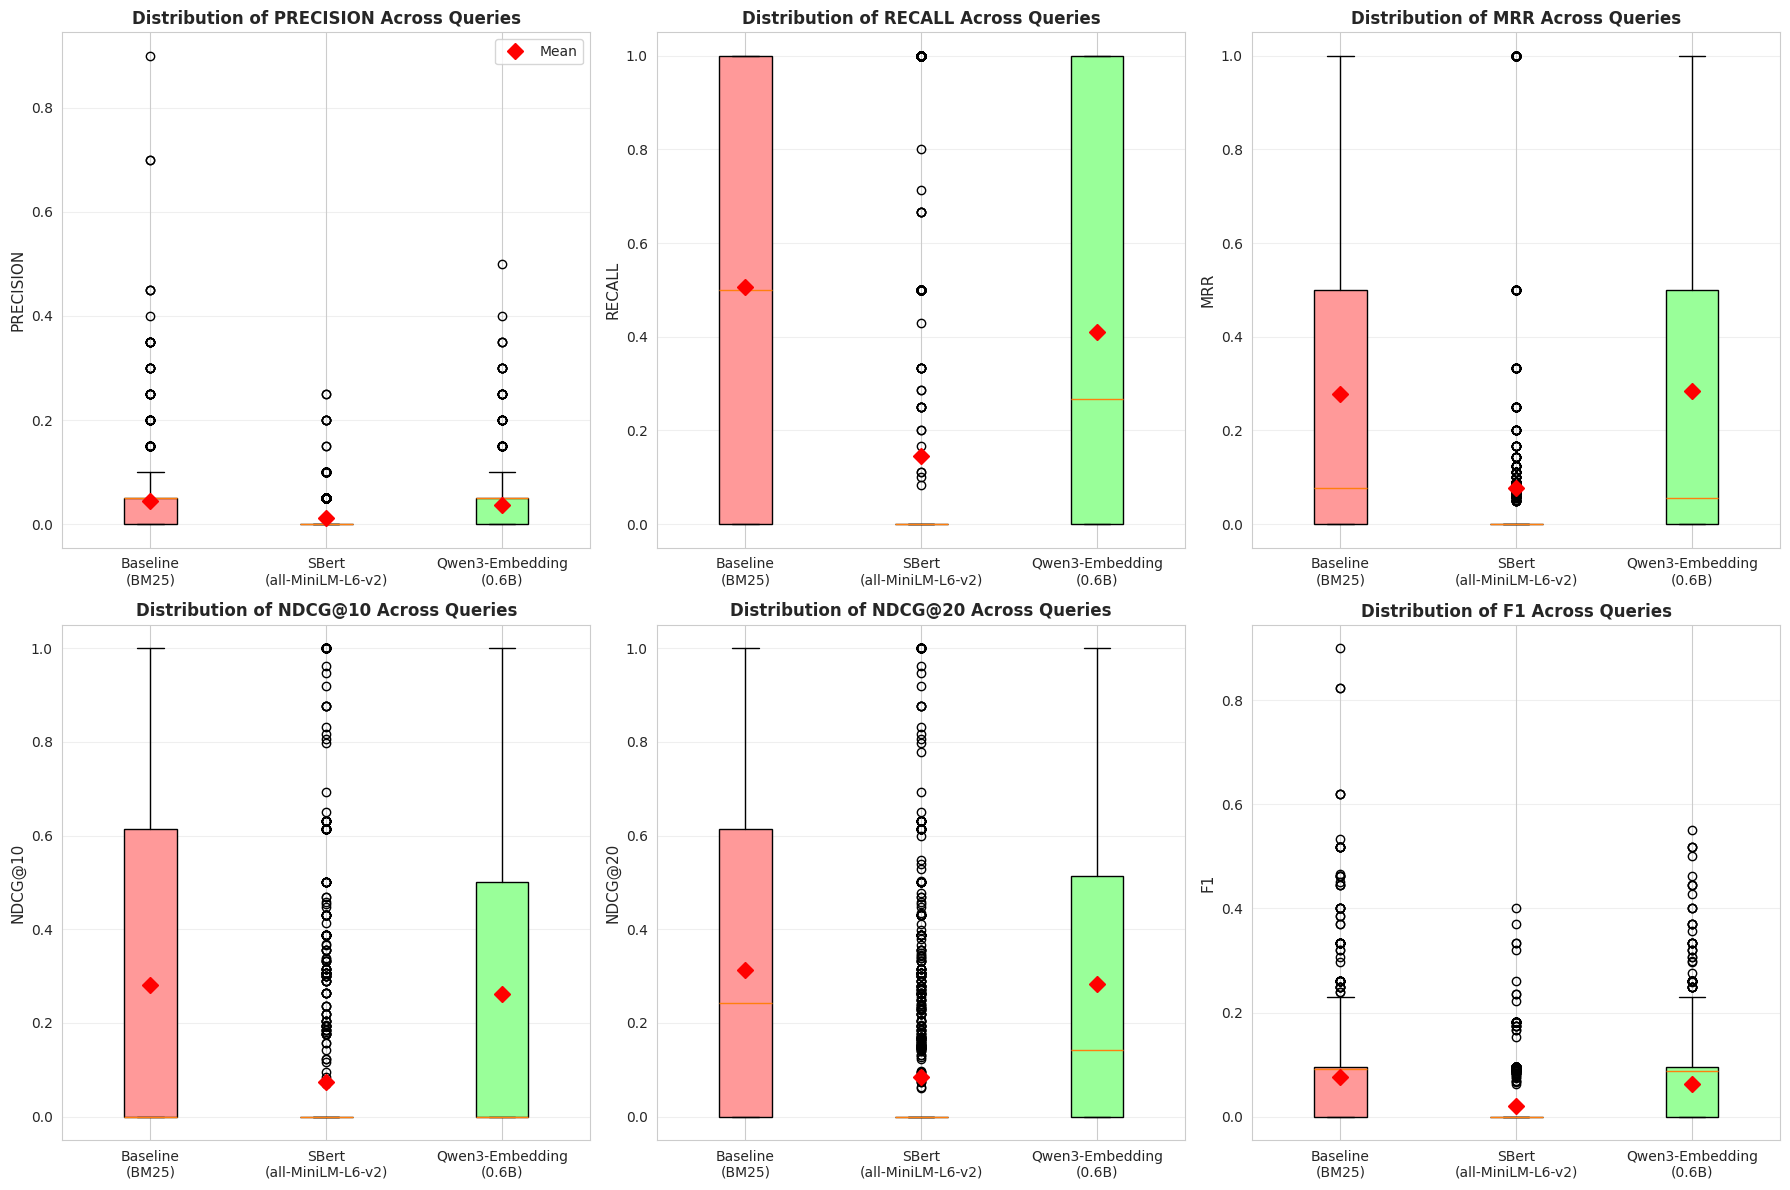

In [31]:
# Create box plots showing per-query metric distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_test):
    ax = axes[idx]

    # Prepare data for box plot
    data_to_plot = [
        baseline_per_query[metric].values,
        sbert_per_query[metric].values,
        qwen3_per_query[metric].values,
    ]

    bp = ax.boxplot(
        data_to_plot,
        tick_labels=[
            "Baseline\n(BM25)",
            "SBert\n(all-MiniLM-L6-v2)",
            "Qwen3-Embedding\n(0.6B)",
        ],
        patch_artist=True,
        showfliers=True,
    )

    # Color the boxes
    colors = ["#ff9999", "#99ccff", "#99ff99"]
    for patch, color in zip(bp["boxes"], colors, strict=False):
        patch.set_facecolor(color)

    ax.set_ylabel(metric.upper(), fontsize=11)
    ax.set_title(
        f"Distribution of {metric.upper()} Across Queries",
        fontsize=12,
        fontweight="bold",
    )
    ax.grid(True, alpha=0.3, axis="y")

    # Add mean markers
    means = [np.mean(d) for d in data_to_plot]
    ax.plot(range(1, 4), means, "D", color="red", markersize=8, label="Mean", zorder=3)

    if idx == 0:
        ax.legend()

plt.tight_layout()
plt.show()

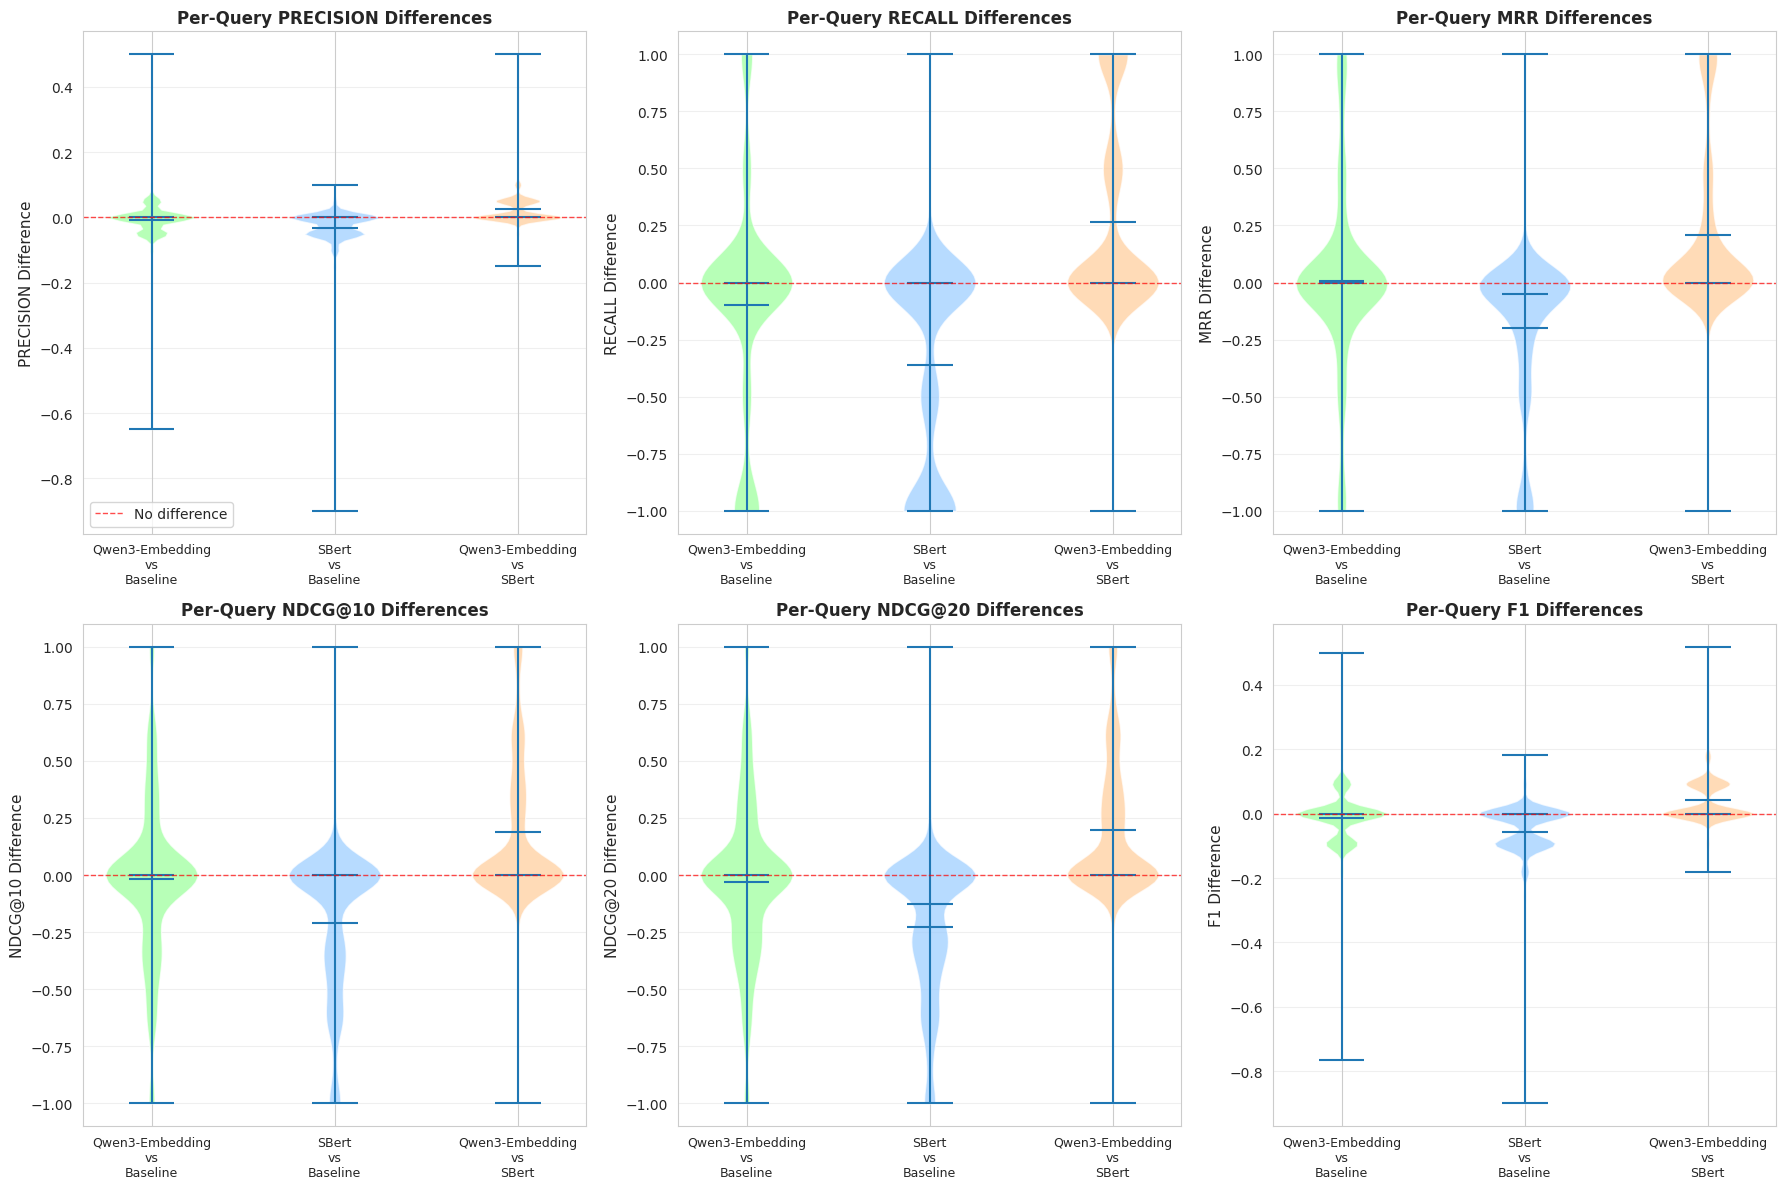

In [32]:
# Create violin plots showing per-query differences
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_test):
    ax = axes[idx]

    # Calculate differences
    qwen3_vs_baseline_diff = (
        qwen3_per_query[metric].values - baseline_per_query[metric].values
    )
    sbert_vs_baseline_diff = (
        sbert_per_query[metric].values - baseline_per_query[metric].values
    )
    qwen3_vs_sbert_diff = (
        qwen3_per_query[metric].values - sbert_per_query[metric].values
    )

    # Prepare data for violin plot
    diff_data = pd.DataFrame({
        "Difference": np.concatenate([
            qwen3_vs_baseline_diff,
            sbert_vs_baseline_diff,
            qwen3_vs_sbert_diff,
        ]),
        "Comparison": ["Qwen3-Embedding vs Baseline"] * len(qwen3_vs_baseline_diff)
        + ["SBert vs Baseline"] * len(sbert_vs_baseline_diff)
        + ["Qwen3-Embedding vs SBert"] * len(qwen3_vs_sbert_diff),
    })

    # Create violin plot
    parts = ax.violinplot(
        [qwen3_vs_baseline_diff, sbert_vs_baseline_diff, qwen3_vs_sbert_diff],
        positions=[1, 2, 3],
        showmeans=True,
        showmedians=True,
    )

    # Color the violins
    colors = ["#99ff99", "#99ccff", "#ffcc99"]
    for pc, color in zip(parts["bodies"], colors, strict=False):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)

    # Add zero line
    ax.axhline(
        y=0, color="red", linestyle="--", linewidth=1, alpha=0.7, label="No difference"
    )

    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(
        [
            "Qwen3-Embedding\nvs\nBaseline",
            "SBert\nvs\nBaseline",
            "Qwen3-Embedding\nvs\nSBert",
        ],
        fontsize=9,
    )
    ax.set_ylabel(f"{metric.upper()} Difference", fontsize=11)
    ax.set_title(
        f"Per-Query {metric.upper()} Differences", fontsize=12, fontweight="bold"
    )
    ax.grid(True, alpha=0.3, axis="y")

    if idx == 0:
        ax.legend()

plt.tight_layout()
plt.show()

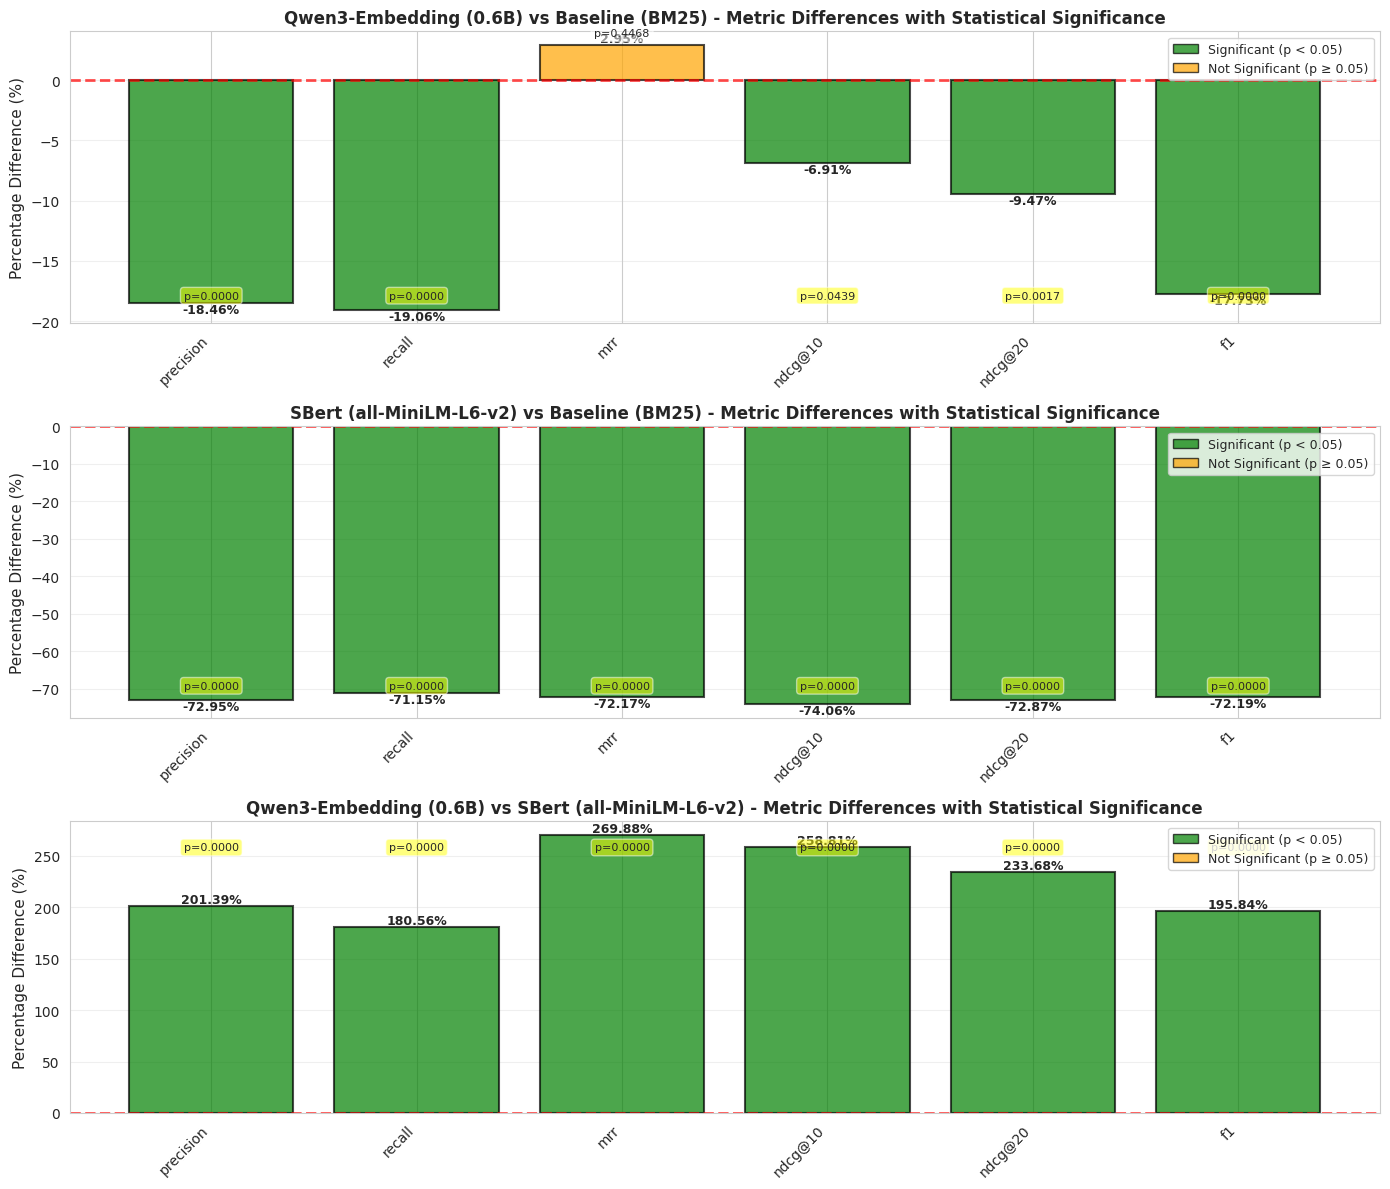

In [33]:
# Create comprehensive significance visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

comparisons = [
    ("Qwen3-Embedding (0.6B) vs Baseline (BM25)", qwen3_vs_baseline_df),
    ("SBert (all-MiniLM-L6-v2) vs Baseline (BM25)", sbert_vs_baseline_df),
    ("Qwen3-Embedding (0.6B) vs SBert (all-MiniLM-L6-v2)", qwen3_vs_sbert_df),
]

for idx, (comparison_name, df) in enumerate(comparisons):
    ax = axes[idx]

    # Create bar chart for differences
    x_pos = np.arange(len(df))
    colors = [
        "green" if sig == "Yes" else "orange" for sig in df["Significant (α=0.05)"]
    ]

    bars = ax.bar(
        x_pos,
        df["Difference (%)"],
        color=colors,
        alpha=0.7,
        edgecolor="black",
        linewidth=1.5,
    )

    # Add value labels on bars
    for _i, (bar, val) in enumerate(zip(bars, df["Difference (%)"], strict=False)):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{val:.2f}%",
            ha="center",
            va="bottom" if height > 0 else "top",
            fontsize=9,
            fontweight="bold",
        )

    # Add PAR p-values as text
    for i, (x, p_val) in enumerate(zip(x_pos, df["PAR p-value"], strict=False)):
        y_pos = (
            ax.get_ylim()[1] * 0.9
            if df["Difference (%)"].iloc[i] > 0
            else ax.get_ylim()[0] * 0.9
        )
        ax.text(
            x,
            y_pos,
            f"p={p_val:.4f}",
            ha="center",
            fontsize=8,
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="yellow" if p_val < 0.05 else "white",
                alpha=0.5,
            ),
        )

    ax.axhline(y=0, color="red", linestyle="--", linewidth=2, alpha=0.7)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(df["Metric"], rotation=45, ha="right")
    ax.set_ylabel("Percentage Difference (%)", fontsize=11)
    ax.set_title(
        f"{comparison_name} - Metric Differences with Statistical Significance",
        fontsize=12,
        fontweight="bold",
    )
    ax.grid(True, alpha=0.3, axis="y")

    # Add legend
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(
            facecolor="green",
            alpha=0.7,
            edgecolor="black",
            label="Significant (p < 0.05)",
        ),
        Patch(
            facecolor="orange",
            alpha=0.7,
            edgecolor="black",
            label="Not Significant (p ≥ 0.05)",
        ),
    ]
    ax.legend(handles=legend_elements, loc="upper right", fontsize=9)

plt.tight_layout()
plt.show()

## 6. Generation Metrics Comparison

Let's also compare the generation metrics across the three configurations.

GLOBAL GENERATION METRICS COMPARISON


,Exact Match,F1 Score,ROUGE-L F1,Answer Relevance,Support Coverage,Support Density,Hallucination Rate,SBert Similarity,Cross-Encoder Sim
Configuration,,,,,,,,,
Baseline (BM25),0.0,0.1276,0.1146,0.3420,1.0000,1.0000,0.0000,0.2770,0.0495
SBert (all-MiniLM-L6-v2),0.0,0.1487,0.1472,0.1557,0.3062,0.2512,0.7488,0.2065,0.0313
Qwen3-Embedding (0.6B),0.0,0.1759,0.1725,0.2494,0.4331,0.4044,0.5956,0.2751,0.0876


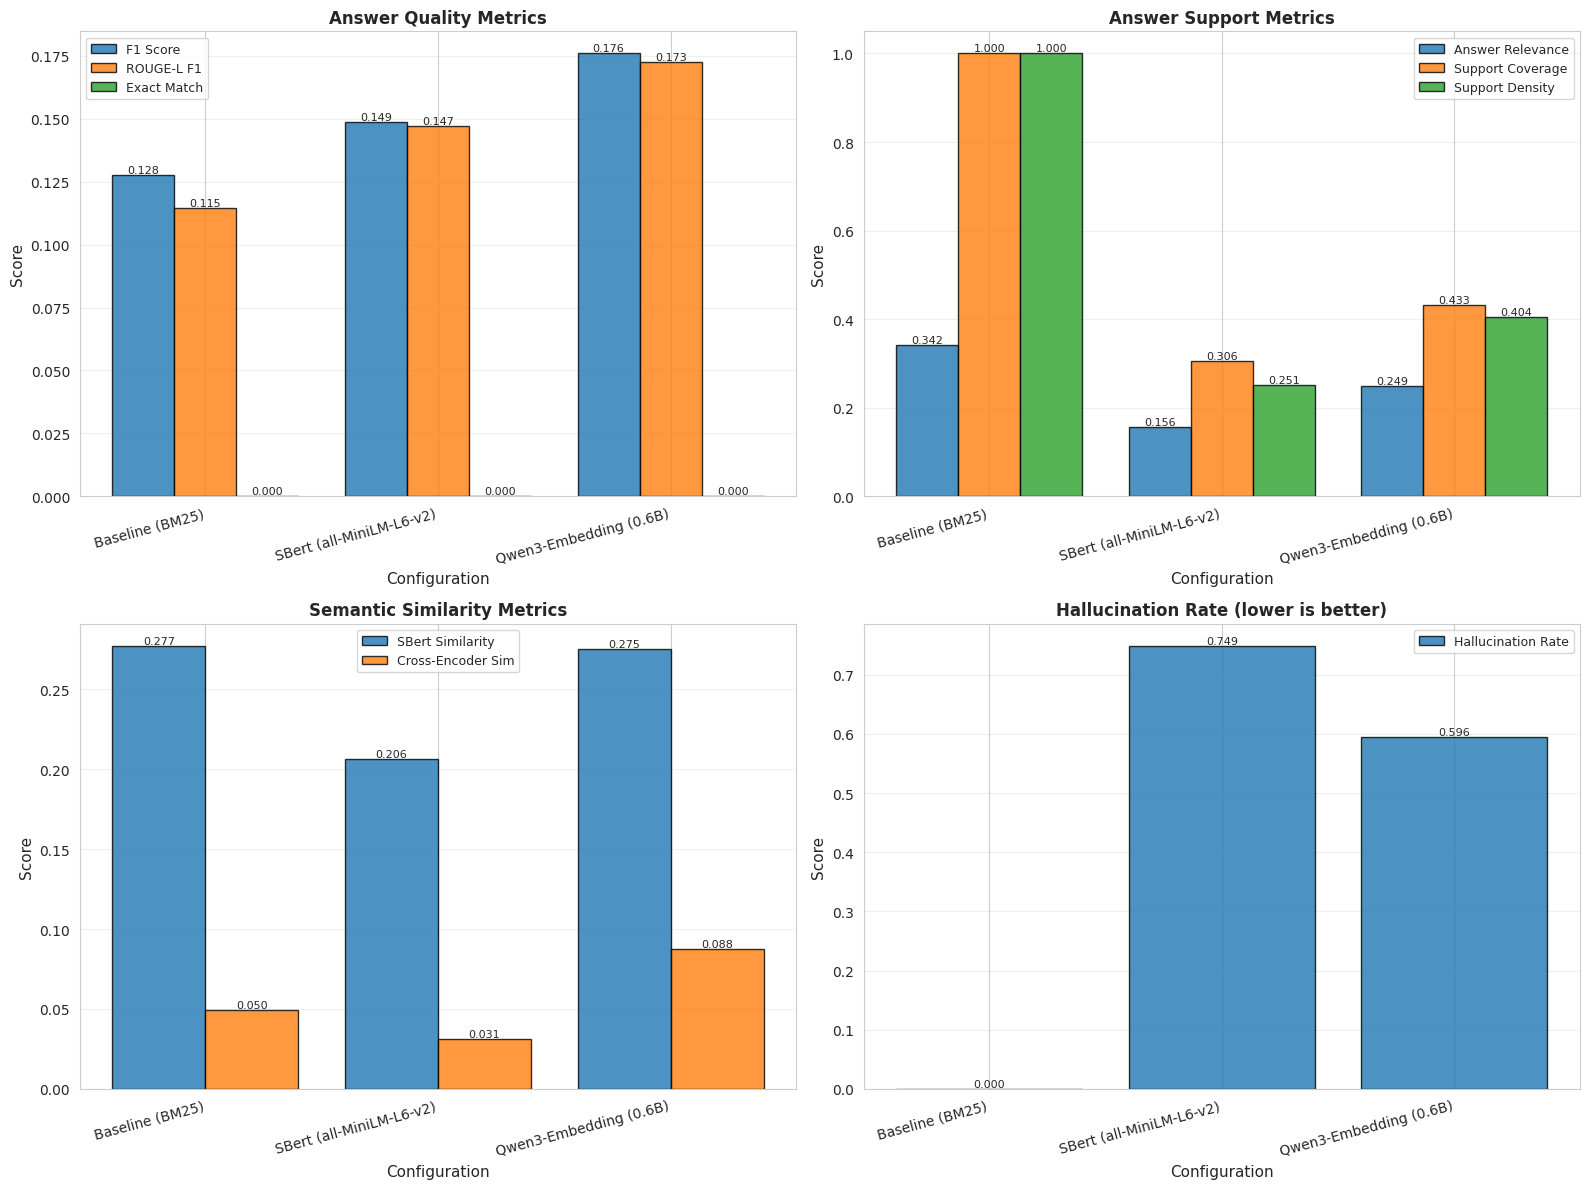

In [34]:
# Extract global generation metrics
def extract_generation_metrics(data, config_name):
    metrics = data["generation_metrics"]
    return {
        "Configuration": config_name,
        "Exact Match": metrics["exact_match"],
        "F1 Score": metrics["f1"],
        "ROUGE-L F1": metrics["rouge_l_f1"],
        "Answer Relevance": metrics["answer_relevance"],
        "Support Coverage": metrics["support_coverage"],
        "Support Density": metrics["support_density"],
        "Hallucination Rate": metrics["hallucination_rate"],
        "SBert Similarity": metrics["sbert_similarity"],
        "Cross-Encoder Sim": metrics["cross_encoder_similarity"],
    }


generation_metrics = pd.DataFrame([
    extract_generation_metrics(baseline_data, "Baseline (BM25)"),
    extract_generation_metrics(sbert_data, "SBert (all-MiniLM-L6-v2)"),
    extract_generation_metrics(qwen3_data, "Qwen3-Embedding (0.6B)"),
])

print("=" * 100)
print("GLOBAL GENERATION METRICS COMPARISON")
print("=" * 100)
display(generation_metrics.set_index("Configuration").round(4))

# Visualize generation metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metric_groups = [
    (["F1 Score", "ROUGE-L F1", "Exact Match"], "Answer Quality Metrics", 0),
    (
        ["Answer Relevance", "Support Coverage", "Support Density"],
        "Answer Support Metrics",
        1,
    ),
    (["SBert Similarity", "Cross-Encoder Sim"], "Semantic Similarity Metrics", 2),
    (["Hallucination Rate"], "Hallucination Rate (lower is better)", 3),
]

for metric_cols, title, ax_idx in metric_groups:
    ax = axes[ax_idx]

    # Prepare data
    x = np.arange(len(generation_metrics))
    width = 0.8 / len(metric_cols)

    for i, metric in enumerate(metric_cols):
        offset = (i - len(metric_cols) / 2) * width + width / 2
        bars = ax.bar(
            x + offset,
            generation_metrics[metric],
            width,
            label=metric,
            alpha=0.8,
            edgecolor="black",
            linewidth=1,
        )

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{height:.3f}",
                ha="center",
                va="bottom",
                fontsize=8,
            )

    ax.set_xlabel("Configuration", fontsize=11)
    ax.set_ylabel("Score", fontsize=11)
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(generation_metrics["Configuration"], rotation=15, ha="right")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## 7. Summary and Key Findings

Let's create a final summary comparing all configurations.

COMPREHENSIVE SUMMARY TABLE - OPENLIFELOGQA EVALUATION


,Precision@20,Recall@20,MRR,NDCG@10,AQWV,MAP,F1 (Gen),ROUGE-L,Support Coverage,Hallucination Rate,Avg Response Time (s)
Configuration,,,,,,,,,,,
Baseline (BM25),0.0440,0.5071,0.2768,0.2814,0.4793,0.2369,0.1276,0.1146,1.0000,0.0000,0.0054
SBert (all-MiniLM-L6-v2),0.0119,0.1463,0.0770,0.0730,0.1176,0.0592,0.1487,0.1472,0.3062,0.7488,0.4556
Qwen3-Embedding (0.6B),0.0359,0.4105,0.2850,0.2619,0.3825,0.2201,0.1759,0.1725,0.4331,0.5956,0.7555


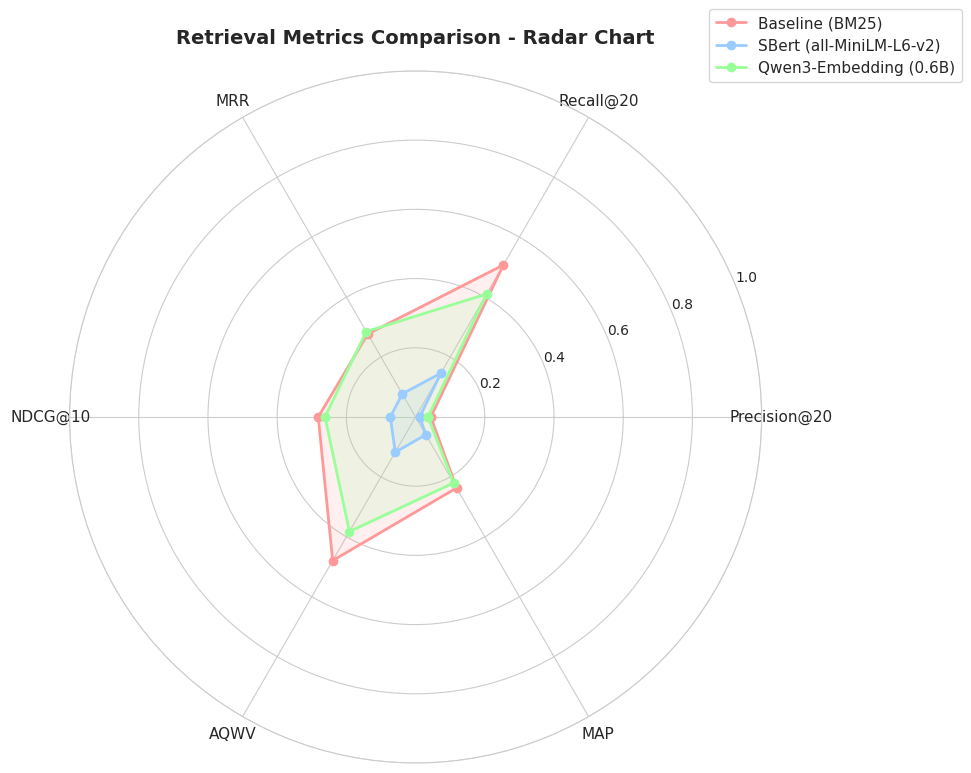


KEY FINDINGS

1. RETRIEVAL PERFORMANCE:
   - Qwen3-Embedding (0.6B) achieves MRR of 0.2850
   - SBert (all-MiniLM-L6-v2) achieves MRR of 0.0770
   - Baseline (BM25) achieves MRR of 0.2768
   - Qwen3-Embedding shows 2.95% improvement over baseline in MRR
   - SBert shows -72.17% improvement over baseline in MRR

2. PRECISION-RECALL TRADE-OFF:
   - Qwen3-Embedding (0.6B): Precision@20=0.0359, Recall@20=0.4105
   - SBert (all-MiniLM-L6-v2): Precision@20=0.0119, Recall@20=0.1463
   - Baseline: Precision@20=0.0440, Recall@20=0.5071

3. GENERATION QUALITY:
   - Qwen3-Embedding (0.6B) achieves F1 score of 0.1759
   - SBert (all-MiniLM-L6-v2) achieves F1 score of 0.1487
   - Baseline achieves F1 score of 0.1276
   - Hallucination rates: Qwen3-Embedding=0.5956, SBert=0.7488, Baseline=0.0000

4. STATISTICAL SIGNIFICANCE:
   - Differences between dense embedding approaches (Qwen3-Embedding 0.6B and SBert)
     and Baseline are evaluated for statistical significance
   - (see detailed tables abov

In [35]:
from math import pi

# Create comprehensive summary table
summary_data = []

for config_name, data in [
    ("Baseline (BM25)", baseline_data),
    ("SBert (all-MiniLM-L6-v2)", sbert_data),
    ("Qwen3-Embedding (0.6B)", qwen3_data),
]:
    ret_metrics = data["retrieval_metrics"]
    gen_metrics = data["generation_metrics"]

    summary_data.append({
        "Configuration": config_name,
        "Precision@20": ret_metrics["precision@20"],
        "Recall@20": ret_metrics["recall@20"],
        "MRR": ret_metrics["mrr"],
        "NDCG@10": ret_metrics["ndcg@10"],
        "AQWV": ret_metrics["aqwv"],
        "MAP": ret_metrics["map"],
        "F1 (Gen)": gen_metrics["f1"],
        "ROUGE-L": gen_metrics["rouge_l_f1"],
        "Support Coverage": gen_metrics["support_coverage"],
        "Hallucination Rate": gen_metrics["hallucination_rate"],
        "Avg Response Time (s)": data["avg_response_time"],
    })

summary_df = pd.DataFrame(summary_data)

print("=" * 120)
print("COMPREHENSIVE SUMMARY TABLE - OPENLIFELOGQA EVALUATION")
print("=" * 120)
display(summary_df.set_index("Configuration").round(4))

# Create radar chart for comparison

# Select key metrics for radar chart
radar_metrics = ["Precision@20", "Recall@20", "MRR", "NDCG@10", "AQWV", "MAP"]
num_vars = len(radar_metrics)

# Create figure
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="polar"))

# Compute angle for each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Plot each configuration
colors = ["#ff9999", "#99ccff", "#99ff99"]
for idx, row in summary_df.iterrows():
    values = [row[metric] for metric in radar_metrics]
    values += values[:1]

    ax.plot(
        angles, values, "o-", linewidth=2, label=row["Configuration"], color=colors[idx]
    )
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

# Fix axis to go in the right order
ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_metrics, size=11)
ax.set_ylim(0, 1)
ax.set_title(
    "Retrieval Metrics Comparison - Radar Chart", size=14, fontweight="bold", pad=20
)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.grid(True)

plt.tight_layout()
plt.show()

# Print key findings
print("\n" + "=" * 120)
print("KEY FINDINGS")
print("=" * 120)
print("\n1. RETRIEVAL PERFORMANCE:")
qwen3_mrr = qwen3_data["retrieval_metrics"]["mrr"]
sbert_mrr = sbert_data["retrieval_metrics"]["mrr"]
baseline_mrr = baseline_data["retrieval_metrics"]["mrr"]
print(f"   - Qwen3-Embedding (0.6B) achieves MRR of {qwen3_mrr:.4f}")
print(f"   - SBert (all-MiniLM-L6-v2) achieves MRR of {sbert_mrr:.4f}")
print(f"   - Baseline (BM25) achieves MRR of {baseline_mrr:.4f}")
mrr_improvement_qwen3 = (qwen3_mrr - baseline_mrr) / baseline_mrr * 100
mrr_improvement_sbert = (sbert_mrr - baseline_mrr) / baseline_mrr * 100
print(
    f"   - Qwen3-Embedding shows {mrr_improvement_qwen3:.2f}% improvement over baseline in MRR"
)
print(f"   - SBert shows {mrr_improvement_sbert:.2f}% improvement over baseline in MRR")

print("\n2. PRECISION-RECALL TRADE-OFF:")
qwen3_p20 = qwen3_data["retrieval_metrics"]["precision@20"]
qwen3_r20 = qwen3_data["retrieval_metrics"]["recall@20"]
print(
    f"   - Qwen3-Embedding (0.6B): Precision@20={qwen3_p20:.4f}, Recall@20={qwen3_r20:.4f}"
)
sbert_p20 = sbert_data["retrieval_metrics"]["precision@20"]
sbert_r20 = sbert_data["retrieval_metrics"]["recall@20"]
print(
    f"   - SBert (all-MiniLM-L6-v2): Precision@20={sbert_p20:.4f}, Recall@20={sbert_r20:.4f}"
)
baseline_p20 = baseline_data["retrieval_metrics"]["precision@20"]
baseline_r20 = baseline_data["retrieval_metrics"]["recall@20"]
print(f"   - Baseline: Precision@20={baseline_p20:.4f}, Recall@20={baseline_r20:.4f}")

print("\n3. GENERATION QUALITY:")
qwen3_f1 = qwen3_data["generation_metrics"]["f1"]
sbert_f1 = sbert_data["generation_metrics"]["f1"]
baseline_f1 = baseline_data["generation_metrics"]["f1"]
print(f"   - Qwen3-Embedding (0.6B) achieves F1 score of {qwen3_f1:.4f}")
print(f"   - SBert (all-MiniLM-L6-v2) achieves F1 score of {sbert_f1:.4f}")
print(f"   - Baseline achieves F1 score of {baseline_f1:.4f}")
qwen3_hal = qwen3_data["generation_metrics"]["hallucination_rate"]
sbert_hal = sbert_data["generation_metrics"]["hallucination_rate"]
baseline_hal = baseline_data["generation_metrics"]["hallucination_rate"]
print(
    f"   - Hallucination rates: Qwen3-Embedding={qwen3_hal:.4f}, "
    f"SBert={sbert_hal:.4f}, "
    f"Baseline={baseline_hal:.4f}"
)

print("\n4. STATISTICAL SIGNIFICANCE:")
print(
    "   - Differences between dense embedding approaches (Qwen3-Embedding 0.6B and SBert)"
)
print("     and Baseline are evaluated for statistical significance")
print("   - (see detailed tables above)")
print("   - PAR tests confirm which improvements are not due to random chance")

print("\n5. EFFICIENCY:")
baseline_time = baseline_data["avg_response_time"]
sbert_time = sbert_data["avg_response_time"]
qwen3_time = qwen3_data["avg_response_time"]
print(
    f"   - Average response times: Baseline={baseline_time:.2f}s, "
    f"SBert={sbert_time:.2f}s, Qwen3-Embedding={qwen3_time:.2f}s"
)

print("\n" + "=" * 120)